# Visualizations in Plotly for the DMP Aspect Test Experiment

In [1]:
%matplotlib notebook

In [97]:
import sys
sys.path.append("../../")

from dmp.data.logging import _get_sql_engine
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from joblib import Memory
from ipywidgets import interact, interact_manual
import ipywidgets as widgets

import plotly.graph_objects as go

import scipy
import scipy.interpolate


import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

In [8]:
db = _get_sql_engine()

memory = Memory(location="./cache", verbose=0)

def query(query_string):
    with db.connect() as engine:
        return pd.read_sql(query_string, engine)

cached_query = memory.cache(query)

def clear_cache():
    memory.clear()
    
options = {
    "dataset": ['529_pollen',
        'sleep',
#         'adult',
        '537_houses',
#         'nursery',
        '201_pol',
        'mnist',
        'connect_4',
        'wine_quality_white'],
    "agg": ["avg", "min", "max"],
    "topology" : ["exponential", "rectangle", "trapezoid", "wide_first"],
    "loss": ['history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarity',
       'history_val_mean_squared_error', 'history_root_mean_squared_error',
       'history_val_mean_absolute_error',
       'history_kullback_leibler_divergence',
       'history_val_root_mean_squared_error',
       'history_mean_squared_logarithmic_error',
       'history_val_kullback_leibler_divergence',
       'history_val_mean_squared_logarithmic_error'],
    "residual_mode": ["none", "full"],
    "group_select" : ["min", "max"],
    'depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
    'budget': [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384,
                32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216, 33554432],
    'color_range': (1.05, 2.5, .05),
    'epoch_axis' : ['epoch', 'log_effort', 'effort']
    
}

import plotly.io as pio
pio.templates["dmp_template"] = go.layout.Template(
    layout=go.Layout(
        colorscale={
            'diverging':'Temps',
            'sequential': 'Viridis_r',
            'sequentialminus':'Viridis_r',
#             'sequential': 'Agsunset_r',
#             'sequentialminus':'Agsunset_r',
        }
    )
)
pio.templates.default = 'dmp_template'

In [5]:
clear_cache()

In [21]:
def generate_colors(numColors, colormapName='tab10'):#'nipy_spectral plasma'): #gist_rainbow
    cm = plt.get_cmap(colormapName)
    cNorm  = mpl.colors.Normalize(vmin=0, vmax=numColors-1)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cm)
    return [scalarMap.to_rgba(i) for i in range(numColors)]

def setup_value(df, loss, color_range):
    z_label = loss
    #     df["value"] = -np.log(np.minimum(df["value"], np.min(df["value"])*4))   
#     df["value"] = -np.log(df['value'] / np.min(df['value']))
#     df["value"] = -np.log(df['value'] / np.min(df['value']))
#     df["value"] = -(df['value'] / np.min(df['value']))

    minimizing = True
    if 'accuracy' in loss:
        df['value'] = 1 - df['value']
        df['value'] = np.minimum(np.min(df['value']) * color_range, df['value'])
        df["value"] = np.log(df['value'])/np.log(10)
        z_label = f'log(1-{loss})'
    elif 'loss' in loss:
#         df["value"] = -np.exp(1 - df['value']/np.min(df['value']))
        df['value'] = np.minimum(np.min(df['value']) * color_range, df['value'])
#         df["value"] = -np.log(df['value'])/np.log(10)
#         z_label = f'-log({loss})'
        
        df["value"] = df['value'] / np.abs(np.min(df['value']))
        z_label = f'loss / abs(min(loss))'
#         df["value"] = -np.log(df['value'] / np.min(df['value']))/np.log(10)
#         df["value"] = -df['value'] / np.min(df['value'])
    elif 'error' in loss:
        df["value"] = df['value'] / np.min(df['value'])
        df['value'] = np.minimum(color_range, df['value'])
        z_label = f'error / min(error)'
    
    if minimizing:
        best = np.nanmin(df['value'])
    else:
        best = np.nanmax(df['value'])
        
    return z_label, minimizing, best

def compute_effort(df):
    df["effort"] = (df["epoch"] * df["config.budget"].astype("float")).astype("float")
    df["log_effort"] = np.log(df["effort"]) / np.log(10)
    df['relative_effort'] = df['effort'] / np.min(df['effort'])
    df['relative_log_effort'] = np.log(df['relative_effort']) / np.log(10)


def get_values_for_categorical_keys(df, partition_keys):
    partitions = []
    for partition_key in partition_keys:
        partition_values = sorted(df[partition_key].unique())
        partitions.append(
            (partition_key,
            {key : index for index, key in enumerate(partition_values)},
            partition_values
            ))
    return tuple(partitions)

def partitioned_interpolation(df, partition_keys, interpolation_key, value_key, resolution):
    partitions = get_values_for_categorical_keys(df, partition_keys)
    
    def make_partition_accumulator(i):
        index = partitions[i][1]
        return [make_partition_accumulator(i + 1) if i < len(partitions) - 1 else ([], []) 
                for p in range(len(index))]
    acc = make_partition_accumulator(0)
    
    for _, row in df.iterrows():
        a = acc
        for partition_key, index, _ in partitions:
            a = a[index[row[partition_key]]]
        a[0].append(row[interpolation_key])
        a[1].append(row[value_key])

    interpolation_series = df[interpolation_key]
    interpolation_index = np.linspace(np.min(interpolation_series), np.max(interpolation_series), resolution)
    partition_indexes = [np.linspace(0, len(p), len(p)) for p in partitions]
    
    def do_interpolation(a):
        if type(a) is list:
            return [do_interpolation(p) for p in a]
        func = scipy.interpolate.interp1d(a[0], a[1], kind='linear', bounds_error=False, fill_value=np.NaN)
        return func(interpolation_index)            
    interpolated = np.array(do_interpolation(acc))
    print(f'interpolated {interpolated.shape}')
    return partitions, interpolation_index, interpolated


def make_2d_heatmap_viz(df, groups, dataset, topology, loss, agg, residual_mode, viz, color_range):
    z_label, minimizing, best = setup_value(df, loss, color_range)
        
    if viz == "imshow":
        img = df.pivot_table(columns="epoch", index="config.budget", values="value")
        fig = px.imshow(img)
        fig.update_yaxes(type='category')
    elif viz == "scatter":
        df = df.sort_values(["epoch", "config.budget"], ascending=[True, False])
        df["config.budget"] = df["config.budget"].astype("str")
        df["epoch"] = df["epoch"].astype("str")
        fig = px.scatter(df, x="epoch", y="config.budget", size="count", color="value")
    elif viz == "effort":
        compute_effort(df)
        key = 'log_effort'
        x_res = 4000
        partitions, x_index, interpolated = partitioned_interpolation(df, ['config.budget'], key, 'value', x_res)
        fig= px.imshow(interpolated, aspect='auto', zmin=np.min(interpolated), zmax=np.max(interpolated),
            x = x_index,
            y = [str(b) for b in partitions[0][1]],
            labels=dict(x="log(Effort)", y="# Parameters", color=z_label),)
        fig.update_yaxes(type='category')
    else:
        return None
    fig.update_layout(title=f"{z_label} using {loss} for {dataset}, {topology}, residual {residual_mode}")
    return fig


In [56]:

q = '''
SELECT job_length, "config.budget", "config.topology", "config.depth", "config.dataset", array_length(t.history_val_loss, 1) AS epochs, (job_length/ array_length(t.history_val_loss, 1)) AS epoch_time
FROM
    materialized_experiments_0 t
WHERE
    "groupname" IN ('fixed_01')
'''

# q = '''
# select distinct("name")
# from
#     materialized_experiments_0
# WHERE
#     "groupname" IN ('exp00', 'exp01') and
#     "config.dataset"='537_houses' and
#     "config.topology"='wide_first' and
#     "config.residual_mode"='none' and
#     "config.budget"=262144
# limit 10
# '''

df = cached_query(q)
display(df.columns)
df['epoch_time_s'] = df['epoch_time'].dt.total_seconds()

Index(['job_length', 'config.budget', 'config.topology', 'config.depth',
       'config.dataset', 'epochs', 'epoch_time'],
      dtype='object')

<IPython.core.display.Javascript object>


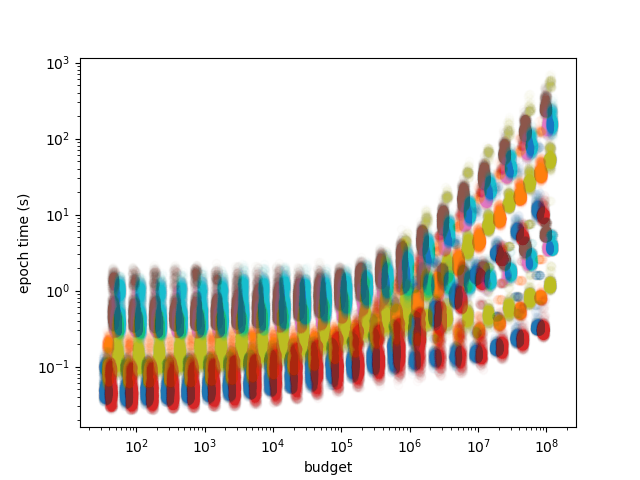

(34320,)


In [57]:
fig, ax = plt.subplots(1)

ax.set_xlabel('budget')
ax.set_xscale('log')

ax.set_ylabel('epoch time (s)')
ax.set_yscale('log')

datasets = list(df['config.dataset'].unique())
colors = generate_colors(len(datasets))
rng = np.random.default_rng(seed=42)

print(rng.random((len(df0))).shape)

for i, dataset in enumerate(datasets):
    df0 = df[df['config.dataset'] == dataset]
    ax.plot(df0['config.budget'] * (.2 * rng.random(df0['config.budget'].shape) + 1 + (.8 / len(datasets)) * i), df0['epoch_time_s'], 'o', color=colors[i], label=dataset, alpha=.01)



# ax.legend()


<IPython.core.display.Javascript object>


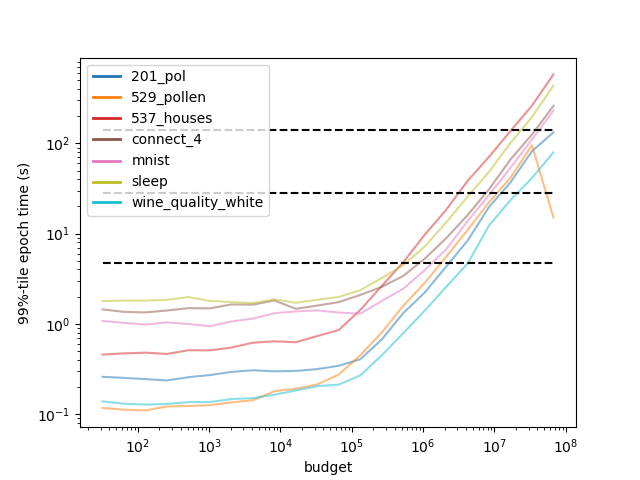

['exponential', 'rectangle', 'trapezoid', 'wide_first']


In [117]:


datasets = list(sorted(df['config.dataset'].unique()))
colors = generate_colors(len(datasets))

groups = df.groupby(['config.dataset', 'config.budget'], as_index=False)
quantiles = groups['epoch_time_s'].quantile([.99])
quantiles.index.set_names(['idx', 'tile'], inplace=True)
quantiles.reset_index(inplace=True, level=1)
# quantiles = quantiles.rename({'level_1':'tile'},inplace=True,axis=1)
# print(quantiles)


fig, ax = plt.subplots(1)
ax.set_xlabel('budget')
ax.set_xscale('log')
ax.set_ylabel('99%-tile epoch time (s)')
ax.set_yscale('log')
for i, dataset in enumerate(datasets):
    subset = quantiles[quantiles['config.dataset'] == dataset]
    for quantile in subset['tile'].unique():
        subset1 = subset[subset['tile'] == quantile]
        ax.plot(subset1['config.budget'], subset1['epoch_time_s'], '-', color=colors[i], alpha=.5)
#     budget_quantiles = budget_groups['epoch_time'].quantile([.99, .95, .9, .8])
#     print(budget_quantiles)
#     quantiles = data['epoch_time'].quantile([.99, .95, .9, .8])
#     ax.plot(data['config.budget'], data['epoch_time'], 'o', color=colors[i], label=dataset, alpha=.5)

lines = [Line2D([0], [0], color=color, lw=2) for color in colors]
ax.legend(lines, datasets, loc='upper left')#, bbox_to_anchor=(1, 0.5))

x = [quantiles['config.budget'].min(), quantiles['config.budget'].max()]
time_limit = (4-.05) * 60 * 60

for epochs in [100, 500, 3000]:
    threshold = time_limit / epochs
    ax.plot(x, [threshold, threshold], '--k')

ax.plot()

print(sorted(df['config.topology'].unique()))



In [116]:
12*60

720